## External libraries

In [1]:
# NOTE: Importing torch the first time will always take a long time!
import torch
import torch.nn as nn
import torch.multiprocessing as mp

# Set the start method as soon as the script starts
mp.set_start_method('spawn', force=True)

import wandb # Optional, for logging

import importlib # reload custom modules when necessary
import os
from hydra import initialize, compose
from omegaconf import OmegaConf

## Suppress warnings

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Custom libraries

In [3]:
import eda, chest_xray_data, train_net, net_theta, pdhg_solver, full_pdhg_net

def reload_custom_modules():
    custom_modules = [eda, chest_xray_data, train_net, net_theta, pdhg_solver, full_pdhg_net]
    for module in custom_modules:
        importlib.reload(module)

reload_custom_modules()

## Configuration

In [4]:
def load_config():
    # https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248?permalink_comment_id=4478589#gistcomment-4478589
    with initialize(version_base=None, config_path="conf"):
        config = compose(config_name='config.yaml')
    return config

config = load_config()
print(OmegaConf.to_yaml(config))

device: cuda
data:
  base_dir: ../data/chest_xray
  max_pixel_value: 255.0
data_loader:
  batch_size: 1
  noise_sigma:
    min: 0.1
    max: 0.5
  transform:
    train:
    - name: Resize
      params:
        size:
        - 256
        - 256
    - name: RandomHorizontalFlip
      params:
        p: 0.5
    - name: RandomVerticalFlip
      params:
        p: 0.5
    - name: RandomRotation
      params:
        degrees: 45
    - name: ToTensor
    - name: Normalize
      params:
        mean:
        - 0.485
        - 0.456
        - 0.406
        std:
        - 0.229
        - 0.224
        - 0.225
    val:
    - name: Resize
      params:
        size:
        - 256
        - 256
    - name: ToTensor
    - name: Normalize
      params:
        mean:
        - 0.485
        - 0.456
        - 0.406
        std:
        - 0.229
        - 0.224
        - 0.225
    test:
    - name: Resize
      params:
        size:
        - 256
        - 256
    - name: ToTensor
    - name: Normalize
 

## Use GPU

In [5]:
# if torch.cuda.is_available():
#     DEVICE = torch.device("cuda")
#     # print(f"Using {torch.cuda.get_device_name(0)}")
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device("mps")
#     # print(f"Using {torch.backends.mps.get_device_name(0)} with MPS")
# else:
#     DEVICE = torch.device("cpu")
#     # print("Using CPU")

# torch.set_default_device(DEVICE)

torch.set_default_device(config.device)
print(f"Using {config.device}")

Using cuda


## Basic checks

In [6]:
!which python
print(f"Torch version: {torch.__version__}")
print(f"Working directory: {os.getcwd()}")
print(f"Current folder: {os.path.basename(os.getcwd())}")
print(f"Sibling folders: {os.listdir('../')}")

/mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/venv/bin/python
Torch version: 2.3.0+cu121
Working directory: /mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/src
Current folder: src
Sibling folders: ['.git', '.gitignore', 'data', 'figures', 'gifs', 'learning', 'Lecture_Note_Template-4.pdf', 'LICENSE', 'meeting-1.jpg', 'Meeting1.md', 'networks', 'outputs', 'paper', 'README-old.md', 'README.md', 'requirements.txt', 'scripts', 'slides', 'src', 'utils', 'venv']


## EDA

### Visualise the data

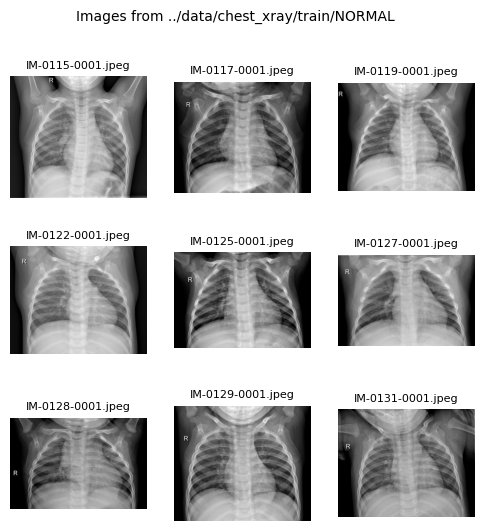

In [7]:
reload_custom_modules()
eda.visualise_images(images_folder=f"{config.data.base_dir}/train/NORMAL")

### Pixel values

In [8]:
reload_custom_modules()
eda.check_pixel_value_range(images_folder=f"{config.data.base_dir}/train/NORMAL")

Image <PIL.JpegImagePlugin.JpegImageFile image mode=L size=2090x1858 at 0x7F947CB7CD30> has pixel values in the range [0, 255]


### Check image dimensions

In [10]:
reload_custom_modules()
eda.check_image_dimensions(config.data.base_dir)

Max width: 2916, max height: 2713
Min width: 384, min height: 127


## Load the data

In [19]:
reload_custom_modules()
chest_xray_data.test_get_data_loader(load_config(), "val", num_images=10)

Number of batches: 8
Noisy image 0 shape: torch.Size([1, 1, 120, 120, 1])
Clean image 0 shape: torch.Size([1, 1, 120, 120, 1])


## Neural Network

In [12]:
net_theta.test_unet()

torch.Size([1, 2, 512, 512, 1])

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d

## Evaluation code

In [13]:
reload_custom_modules()
train_net.test_evaluate()

## Start Training

In [37]:
reload_custom_modules()
config = load_config()

wandb.login()

def get_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=config.train_params.learning_rate)

def get_criterion():
    return nn.MSELoss()

# Optional: Use wandb to log the training process
def get_wandb_logger():

    os.environ['WANDB_NOTEBOOK_NAME'] = config.project_name
    # return wandb.init(project="chest-xray-autoencoder", entity="wandb", reinit=True)

    # start a new wandb run to track this script
    return wandb.init(
            # set the wandb project where this run will be logged
            project=config.project_name,

            # track hyperparameters and run metadata
            config={
                "architecture": config.architecture.model,
                "unet_size": config.architecture.unet_size,
                "unet": net_theta.UNet(),

                "dataset" : config.data.dataset,
                "scale_factor": config.data_loader.scale_factor,
                "patch_size": config.data_loader.patch_size,
                "sigma": config.data_loader.noise_sigma,
                "num_images": config.data_loader.num_images,

                "learning_rate": config.train_params.learning_rate,
                "optimizer": config.train_params.optimizer.name,
                "loss_function": config.train_params.criterion,
                "T": config.train_params.T,
                "up_bound": config.train_params.up_bound,
                "activation": config.train_params.activation,
                "epochs": config.train_params.epochs,
            }
        )

def main():
    wandb_logger = get_wandb_logger()

    with torch.no_grad():
        torch.cuda.empty_cache()

    # model = net_theta.get_example_autoencoder(device=config.device)
    model = full_pdhg_net.DynamicImageStaticPrimalDualNN(
        T=config.train_params.T,
        cnn_block=net_theta.UNet(),
    )
    criterion = get_criterion()
    optimizer = get_optimizer(model)
    
    train_loader, val_loader, test_loader = chest_xray_data.get_data_loaders_all(config, num_images=config.data_loader.num_images)

    train_net.train(
        model, train_loader, val_loader, criterion, optimizer, 
        config.device, epochs=config.train_params.epochs,
        is_multichannel=config.data_loader.is_multichannel, wandb=wandb_logger, save_model_every=config.save_model.epochs, save_model_dir=config.save_model.dir
    )

    train_net.test(model, test_loader, criterion, config.device)
    # wandb.finish()

if __name__ == "__main__":
    main()

# !python3 autoencoder.py
# !python3 autoencoder.py --config=config.yaml
# !python3 autoencoder.py --config=config.yaml --epochs=5
# !python3 autoencoder.py --config=config.yaml --epochs=5 --batch_size=32
# !python3 autoencoder.py --config=config.yaml --epochs=5 --batch_size=32 --learning_rate=0.001
# !python3 autoencoder.py --config=config.yaml --epochs=5 --batch_size=32 --learning_rate=0.001 --device=cuda
# !python3 autoencoder.py --config=config.yaml --epochs=5 --batch_size=32 --learning_rate=0.001 --device=cuda --base_dir=data
# !python3 autoencoder.py --config=config.yaml --epochs=5 --batch_size=32 --learning_rate=0.001 --device=cuda --base_dir=data --wandb=False
# !python3 autoencoder.py --config=config.yaml --epochs=5 --batch_size=32 --learning_rate=0.001 --device=cuda --base_dir=data --wandb=False --seed=42
# !python3 autoencoder.py --config=config.yaml --epochs=5 --batch_size=32 --learning_rate=0.001 --device=cuda --base_dir=data --wandb=False --seed=42 --transform=transform
# !python3 autoencoder.py --config=config.yaml --epochs=5 --batch_size=32 --learning_rate=0.001 --device=cuda --base_dir=data --wandb=False --seed=42 --transform=transform --model=model
# !python3 autoencoder.py --config=config.yaml --epochs=5 --batch_size=32 --learning_rate=0.001 --device=cuda --base_dir=data --wandb=False --seed=42 --transform=transform --model=model --criterion=criterion
# !python3 autoencoder.py --config=config.yaml --epochs=5 --batch_size=32 --learning_rate=0.001 --device=cuda --base_dir=data --wandb=False --seed=42 --transform=transform --model=model --criterion=criterion --optimizer=optimizer
# !python3 autoencoder.py --config=config.yaml --epochs=5 --batch_size=32 --learning_rate=0.001 --device=cuda --base_dir=data --wandb=False --seed=42 --transform=transform --model=model --criterion=criterion --optimizer=optimizer --train=train

wandb: Currently logged in as: trung-vuthanh24 (wof). Use `wandb login --relogin` to force relogin


wandb: ERROR Control-C detected -- Run data was not synced


### Clear the GPU memory

In [16]:
with torch.no_grad():
    torch.cuda.empty_cache()

## Create a server to train the model